# import libraries

In [0]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import csv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


2.2.0-rc3


# define helper functions

In [0]:
def plot_graphs(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('values')
  plt.grid(True)

# function that breaks up dataset into moving windows
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  # add dimension (column) to series
  series = tf.expand_dims(series, axis=-1)
  # ds= dataset
  # create synthetic data
  ds = tf.data.Dataset.from_tensor_slices(series)
  # expand dataset using windowing
  # size of window = window_size + 1 (to include label)
  # shift window by 1 after populating full dataset
  # drop_remainder= ensure all processed datasets are complete, drop partial datasets
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  # flatten into a numpy list per dataset batch of window_size+label for ML processing
  # use a Lambda to add arbitrary code
  # w= window
  ds = ds.flat_map(lambda w: w.batch(window_size + 2))
  # shuffle/randomize to reduce sequence bias   
  ds = ds.shuffle(shuffle_buffer_size)
  # map features and labels, last value = label  
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  # batch the features and respective labels together
  return ds.batch(batch_size).prefetch(1)

# forecast predictions after training
def model_forecast(model, series, window_size):
  # create synthetic data
  ds = tf.data.Dataset.from_tensor_slices(series)
  # size of window = window_size + 1 (to include label)
  # shift window by 1 after populating full dataset
  # drop_remainder= ensure all processed datasets are complete, drop partial datasets
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  # flatten ds into a numpy list per ds batch of window_size partitions
  # use lambda to execute arbitrary code 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  # no need to shuffle, since we're not training
  # batch the features & respective labels together
  ds = ds.batch(batch_size).prefetch(1)
  # predict next value by passing formatted dataset into model
  forecast = model.predict(ds)
  return forecast 

# get dataset

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-04-22 15:05:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-04-22 15:05:11 (85.4 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [0]:
# format dataset
time_step = []
sunspots = []

# open csv file
with open('/tmp/sunspots.csv') as csv_file:
  # use csv library to read csv_file and deliminate (break up) by commas
  reader = csv.reader(csv_file, delimiter=',')
  # skip to next line
  next(reader)
  # loop through reader line-by-line
  # sunspots = column2
  for row in reader:
    # populate lists of respective values, cast to desired data_type
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))


# define hyperparameters 

In [0]:
# convert dataset lists into numpy arrays for ML processing
series = np.array(sunspots)
time = np.array(time_step)

split_time = 3000
window_size = 60
batch_size = 64
shuffle_buffer_size = 1000

# visualize baseline

if possible, id trend and seasonality

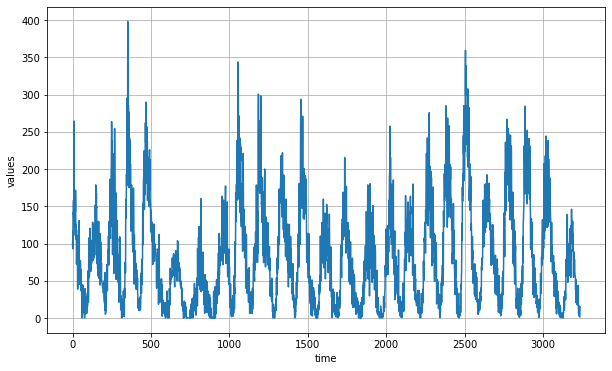

In [0]:
plt.figure(figsize=(10,6))
plot_graphs(time, series)


# split dataset into train & validation subsets

In [0]:
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# define the model

`this model will be the baseline (pre-optimized learning rate)`

use Conv1D + LSTM layers


In [0]:
# reset memory values to prevent side-effects
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


In [0]:
# format dataset
lr_train = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

**padding="causal"**

This simply pads the layer's input with zeros in the front so that we can also predict the values of early time steps in the frame:

![](https://i.stack.imgur.com/NmYZJ.png)

In [0]:
model = tf.keras.Sequential([
  # 32 5x5 filters that detect patterns
  # input_shape of univariate time_series = [None, 1]                             
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal', input_shape=[None, 1]),
  # LSTM cells maintain memory state (context) bidirectionally
  # return_sequences= LSTM feeding layers neuron output match receiving layer neuron input
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
  # no need for a flatten layer since formatted data already flattened
  # fully-connected Dense layers map inputs to outputs
  tf.keras.layers.Dense(units=30, activation='relu'),
  tf.keras.layers.Dense(units=10, activation='relu'),
  # output_layer= single linear regression prediction
  tf.keras.layers.Dense(units=1),
  # use Lambda to increase size of outputs for visualization 
  tf.keras.layers.Lambda(lambda x: x * 400)
])

'''
Total params: weights + hyperparameters
Trainable params: weights
Non-trainable params: hyperparameters
'''
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

# compile the model 

build the model by compiling it with a loss, optimizer, and objective metric

---
**Huber Loss:**

`Huber loss is less sensitive to outliers in data than the squared error loss.`
- It’s basically absolute error, which becomes quadratic when error is small.

However, the problem with Huber loss is that we might need to train hyperparameter delta which is an iterative process.

In [0]:
# sgd= stochastic gradient descent optimizes at each time_step
sgd = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
# mae is great metric if you don't want to heavily punish large errors 
model.compile(loss=tf.keras.losses.Huber(), optimizer=sgd, metrics=['mae'])

# define callbacks 

learningRateScheduler:

`the learning rate scheduler will adjust the learning rate for each epoch`


In [0]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# train the model for optimal LR

fit the model to train & learn the optimal weights

assign trained model to history var for performance querying

In [0]:
history = model.fit(lr_train, epochs=100, callbacks=[lr_scheduler], verbose=0)

# visualize LR performance 

get loss closest to global minimum via gradient descent

(1e-08, 0.0001, 0.0, 60.0)

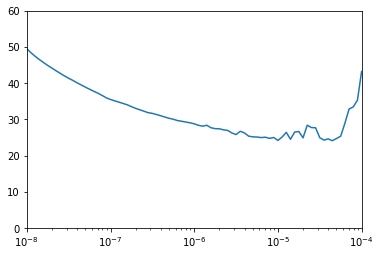

In [0]:
# learning_rates = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

# define the train model

In [0]:
# reset memory values to prevent side-effects
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
# adust batch_size to optimize performance
batch_size = 256
# format training dataset
windowed_train = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

**padding="causal"**

This simply pads the layer's input with zeros in the front so that we can also predict the values of early time steps in the frame:

![](https://i.stack.imgur.com/NmYZJ.png)

In [0]:
model = tf.keras.Sequential([
  # 32 5x5 filters that detect patterns
  # input_shape of univariate time_series = [None, 1]                             
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal', input_shape=[None, 1]),
  # LSTM cells maintain memory state (context) bidirectionally
  # return_sequences= LSTM feeding layers neuron output match receiving layer neuron input
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
  # no need for a flatten layer since formatted data already flattened
  # fully-connected Dense layers map inputs to outputs
  tf.keras.layers.Dense(units=30, activation='relu'),
  tf.keras.layers.Dense(units=10, activation='relu'),
  # output_layer= single linear regression prediction
  tf.keras.layers.Dense(units=1),
  # use Lambda to increase size of outputs for visualization 
  tf.keras.layers.Lambda(lambda x: x * 400)
])

'''
Total params: weights + hyperparameters
Trainable params: weights
Non-trainable params: hyperparameters
'''
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)          

# compile the model with optimal learning rate 

build the model by compiling it with a loss, optimizer, and objective metric

---
**Huber Loss:**

`Huber loss is less sensitive to outliers in data than the squared error loss.`
- It’s basically absolute error, which becomes quadratic when error is small.

However, the problem with Huber loss is that we might need to train hyperparameter delta which is an iterative process.


In [0]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=sgd, metrics=['mae'])

# train optimal LR model

assign train results to history var for performance querying

In [0]:
num_epochs = 500
history = model.fit(windowed_train, epochs=num_epochs)

# get forecast linear regression predictions

newaxis= increase the dimension of the existing array by one more dimension

---

**example:** 

if array= `(4,) aka (4, None)` 

*make it as column vector by inserting an axis along second dimension*

```
new_column_vectors = array[:, np.newaxis]
new_column_vectors.shape = (4, 1)
```

if array= `(, 4) aka (None, 4)` 

*make it as row vector by inserting an axis along first dimension*

```
new_row_vectors = [np.newaxis, :]
new_row_vectors.shape = (1, 4)
```

---


In [0]:
rnn_forecast = model_forecast(model, series=series[..., np.newaxis], window_size=window_size)
rnn_forecast = rnn_forecast[split_time - window_size: -1, -1, 0]

# visualize forecast predictions against validation dataset

`convert into numpy since ML love that format` 

mae= mean absolute deviation/error
- we use absolute values and not penalize large errors as much

mae: 15.313741683959961


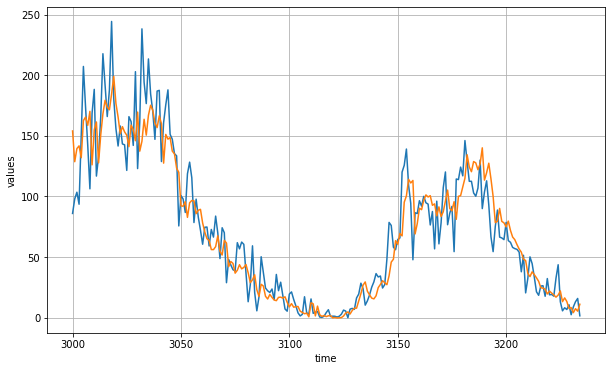

In [0]:
plt.figure(figsize=(10,6))
plot_graphs(time_valid, x_valid)
plot_graphs(time_valid, rnn_forecast)

print('mae: {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()))

<Figure size 432x288 with 0 Axes>

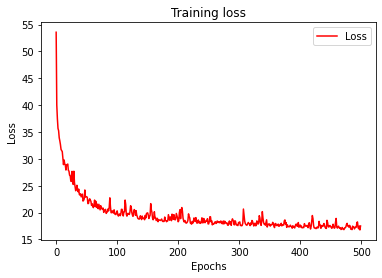

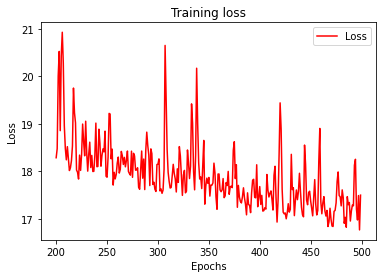

<Figure size 432x288 with 0 Axes>

In [0]:

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

# clean up

terminate memory kernel and free up resources 

In [0]:
import os, signal 

os.kill(os.getpid(), signal.SIGKILL)